In [101]:
nltk.download('vader_lexicon')
nltk.download("stopwords")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [102]:
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import nltk
import pycountry
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from IPython.display import display
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [117]:
# Define Stopwords
stop_words_spa = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
stop_words = stop_words_spa | stop_words_en

In [8]:
# Authentication
consumerKey = "H5WZvHB2u2QNIUh2nE1tPujEc"
consumerSecret = "azBLdKWf7XvI2e6Vakf5aSr3agqVO2QMEnenvzdCyPhi9S0X31"
accessToken = "283024833-pEvPB83WO5q2WE3UXNq6o0EVuziIbDiKE9f8PFNM"
accessTokenSecret = "HIdTJUlsT1robI8ECbY7hVOdmTLEAzfQG2OFtNNVXcf9N"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

# Tweets extraction and visualization

In [119]:

#Function to Create Wordcloud

def create_wordcloud(text):
    mask = np.array(Image.open("cloud.png"))
    #stopwords = set(stop_words)
    wc = WordCloud(background_color="black",
                  mask = mask,
                  max_words=3000,
                  stopwords=stop_words,
                  collocations=False,
                  colormap='Pastel1',
                  repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

def get_tweets(user=0, keyword=0,wc=0):
    #Sentiment Analysis
    def percentage(part,whole):
        return 100 * float(part)/float(whole) 

    if keyword==1:
        keyword = input("Please enter keyword or hashtag to search: ")
        noOfTweet = int(input ("Please enter how many tweets to analyze: "))
        tweets = tweepy.Cursor(api.search_tweets, q=keyword,lang="es").items(noOfTweet)

        positive  = 0
        negative = 0
        neutral = 0
        polarity = 0
        tweet_list = []
        neutral_list = []
        negative_list = []
        positive_list = []

        for tweet in tweets:
            tweet_list.append(tweet.text)
            analysis = TextBlob(tweet.text)
            score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
            neg = score['neg']
            neu = score['neu']
            pos = score['pos']
            comp = score['compound']
            polarity += analysis.sentiment.polarity

            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1

            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1

        positive = percentage(positive, noOfTweet)
        negative = percentage(negative, noOfTweet)
        neutral = percentage(neutral, noOfTweet)
        polarity = percentage(polarity, noOfTweet)
        positive = format(positive, '.1f')
        negative = format(negative, '.1f')
        neutral = format(neutral, '.1f')

        #Number of Tweets (Total, Positive, Negative, Neutral)
        tweet_list = pd.DataFrame(tweet_list)
        neutral_list = pd.DataFrame(neutral_list)
        negative_list = pd.DataFrame(negative_list)
        positive_list = pd.DataFrame(positive_list)
        print("total number: ",len(tweet_list))
        print("positive number: ",len(positive_list))
        print("negative number: ", len(negative_list))
        print("neutral number: ",len(neutral_list))

        #Creating PieCart

        labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
        sizes = [positive, neutral, negative]
        colors = ['lightblue','lightsteelblue','palevioletred']
        #colors2 = sns.color_palette('pastel')[0:5]
        patches, texts = plt.pie(sizes,colors=colors, startangle=90)
        plt.style.use('default')
        plt.legend(labels)
        plt.title(f'Sentiment Analysis result for keyword: "{keyword}"')
        plt.axis('equal')
        plt.show()

        if wc==1:

            #Extract words and make wordcloud

            tw_list = pd.DataFrame(tweet_list)
            tw_list["text"] = tw_list[0]

            #Removing RT, Punctuation etc
            remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
            rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
            tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
            tw_list["text"] = tw_list.text.str.lower()

            #Calculating Negative, Positive, Neutral and Compound values

            tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
            for index, row in tw_list['text'].iteritems():
                score = SentimentIntensityAnalyzer().polarity_scores(row)
                neg = score['neg']
                neu = score['neu']
                pos = score['pos']
                comp = score['compound']
                if neg > pos:
                    tw_list.loc[index, 'sentiment'] = "negative"
                elif pos > neg:
                    tw_list.loc[index, 'sentiment'] = "positive"
                else:
                    tw_list.loc[index, 'sentiment'] = "neutral"
                tw_list.loc[index, 'neg'] = neg
                tw_list.loc[index, 'neu'] = neu
                tw_list.loc[index, 'pos'] = pos
                tw_list.loc[index, 'compound'] = comp

            tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
            tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
            tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

            # WordCloud for all words
            print('Word Cloud for all words')
            create_wordcloud(tw_list["text"].values)

            print('Word Cloud for positive words')
            #Creating wordcloud for positive sentiment
            create_wordcloud(tw_list_positive["text"].values)
            print('Word Cloud for negative words')
            #Creating wordcloud for negative sentiment
            create_wordcloud(tw_list_negative["text"].values)
            print('Word Cloud for neutral words')
            #Creating wordcloud for neutral sentiment
            create_wordcloud(tw_list_neutral["text"].values)

    if user==1:
        user=input("Please enter account name to search: ")
        noOfTweet = int(input ("Please enter how many tweets to analyze: "))
        tweets = tweepy.Cursor(api.user_timeline, screen_name=user).items(noOfTweet)

        positive  = 0
        negative = 0
        neutral = 0
        polarity = 0
        tweet_list = []
        neutral_list = []
        negative_list = []
        positive_list = []

        for tweet in tweets:
            tweet_list.append(tweet.text)
            analysis = TextBlob(tweet.text)
            score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
            neg = score['neg']
            neu = score['neu']
            pos = score['pos']
            comp = score['compound']
            polarity += analysis.sentiment.polarity

            if neg > pos:
                negative_list.append(tweet.text)
                negative += 1

            elif pos > neg:
                positive_list.append(tweet.text)
                positive += 1
            
            elif pos == neg:
                neutral_list.append(tweet.text)
                neutral += 1

        positive = percentage(positive, noOfTweet)
        negative = percentage(negative, noOfTweet)
        neutral = percentage(neutral, noOfTweet)
        polarity = percentage(polarity, noOfTweet)
        positive = format(positive, '.1f')
        negative = format(negative, '.1f')
        neutral = format(neutral, '.1f')

        #Number of Tweets (Total, Positive, Negative, Neutral)
        tweet_list = pd.DataFrame(tweet_list)
        neutral_list = pd.DataFrame(neutral_list)
        negative_list = pd.DataFrame(negative_list)
        positive_list = pd.DataFrame(positive_list)
        print("total number: ",len(tweet_list))
        print("positive number: ",len(positive_list))
        print("negative number: ", len(negative_list))
        print("neutral number: ",len(neutral_list))

        #Creating PieCart

        labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
        sizes = [positive, neutral, negative]
        colors = ['lightblue','lightsteelblue','palevioletred']
        #colors2 = sns.color_palette('pastel')[0:5]
        patches, texts = plt.pie(sizes,colors=colors, startangle=90)
        plt.style.use('default')
        plt.legend(labels)
        plt.title(f'Sentiment Analysis result for user: "{user}"')
        plt.axis('equal')
        plt.show()

        if wc==1:
            #Extract words and make wordcloud

            tw_list = pd.DataFrame(tweet_list)
            tw_list["text"] = tw_list[0]

            #Removing RT, Punctuation etc
            remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
            rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
            tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
            tw_list["text"] = tw_list.text.str.lower()

            #Calculating Negative, Positive, Neutral and Compound values

            tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
            for index, row in tw_list['text'].iteritems():
                score = SentimentIntensityAnalyzer().polarity_scores(row)
                neg = score['neg']
                neu = score['neu']
                pos = score['pos']
                comp = score['compound']
                if neg > pos:
                    tw_list.loc[index, 'sentiment'] = "negative"
                elif pos > neg:
                    tw_list.loc[index, 'sentiment'] = "positive"
                else:
                    tw_list.loc[index, 'sentiment'] = "neutral"
                tw_list.loc[index, 'neg'] = neg
                tw_list.loc[index, 'neu'] = neu
                tw_list.loc[index, 'pos'] = pos
                tw_list.loc[index, 'compound'] = comp

            tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
            tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
            tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

            # WordCloud for all words
            print('Word Cloud for all words')
            create_wordcloud(tw_list["text"].values)

            print('Word Cloud for positive words')
            #Creating wordcloud for positive sentiment
            create_wordcloud(tw_list_positive["text"].values)
            print('Word Cloud for negative words')
            #Creating wordcloud for negative sentiment
            create_wordcloud(tw_list_negative["text"].values)
            print('Word Cloud for neutral words')
            #Creating wordcloud for neutral sentiment
            create_wordcloud(tw_list_neutral["text"].values)

        if user==0 and keyword==0:
            print('Por favor, introduzca uno de los valores "user" o "keyword" con valor igual 1: "user=1" / "keyword=1')

        #return keyword, positive, negative, neutral, polarity, tweet_list, neutral_list, negative_list, positive_list

total number:  50
positive number:  23
negative number:  4
neutral number:  23


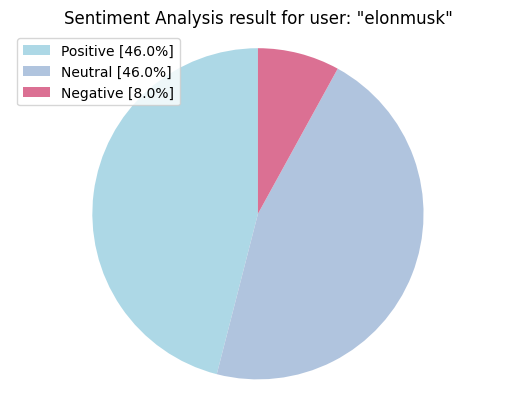

Word Cloud for all words
Word Cloud Saved Successfully


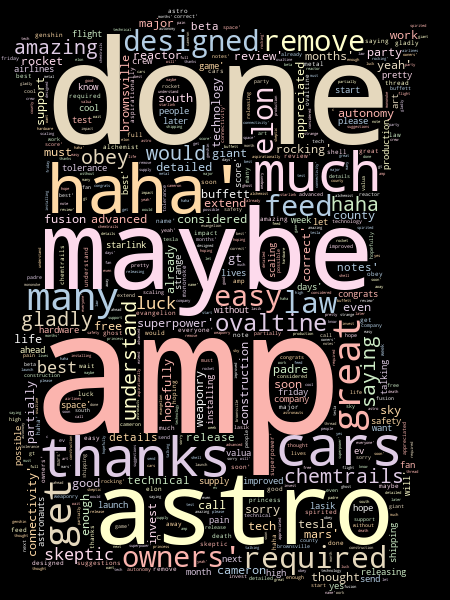

Word Cloud for positive words
Word Cloud Saved Successfully


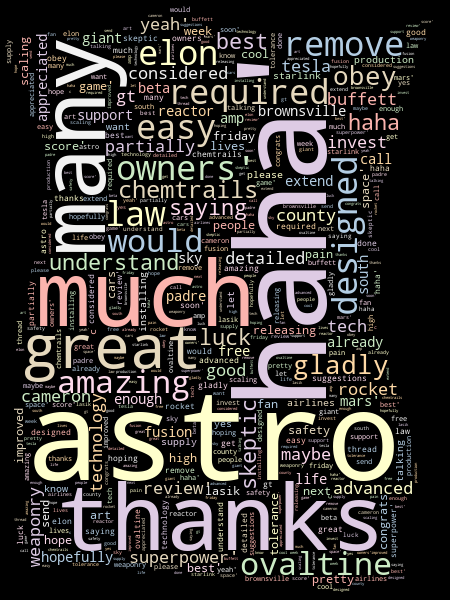

Word Cloud for negative words
Word Cloud Saved Successfully


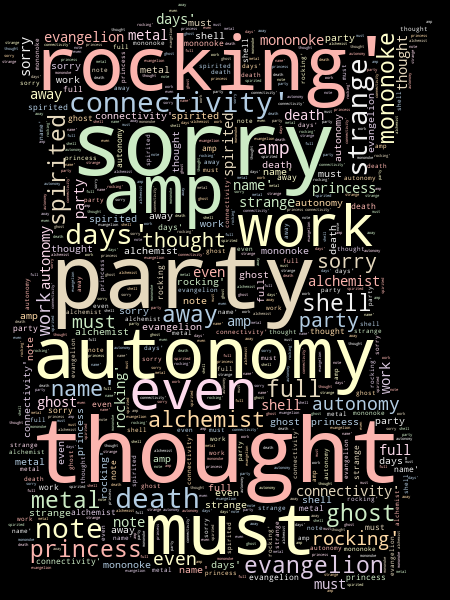

Word Cloud for neutral words
Word Cloud Saved Successfully


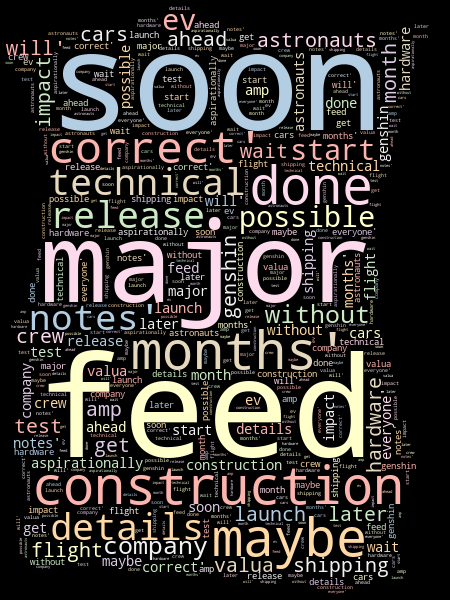

In [121]:
get_tweets(user=1,wc=1)